In [30]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [33]:
#Kp and ap data from 1932
Kpdata = pd.read_csv('kp_ap_since_1932.txt', skiprows=29, sep='\s+', header=0, index_col=False)

#Sunspot data from 1818 
sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'])
#sndata.columns = ['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error', 'obs_num']

C:\Users\jackb\AppData\Local\Temp\ipykernel_17420\2436352326.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'])


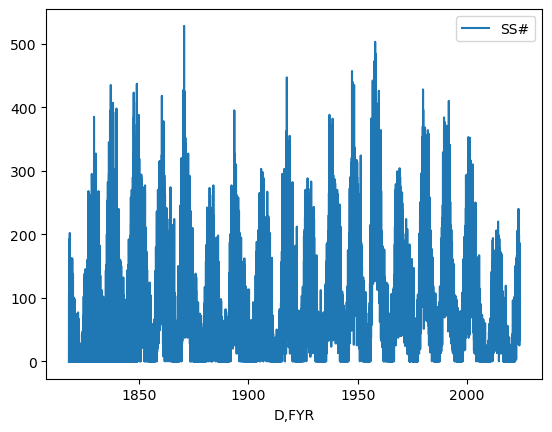

In [52]:
#plot sndata SS# vs D,FYR as a line
sndata.plot(x='D,FYR', y='SS#', kind='line')
legend = ['Sunspot Number']

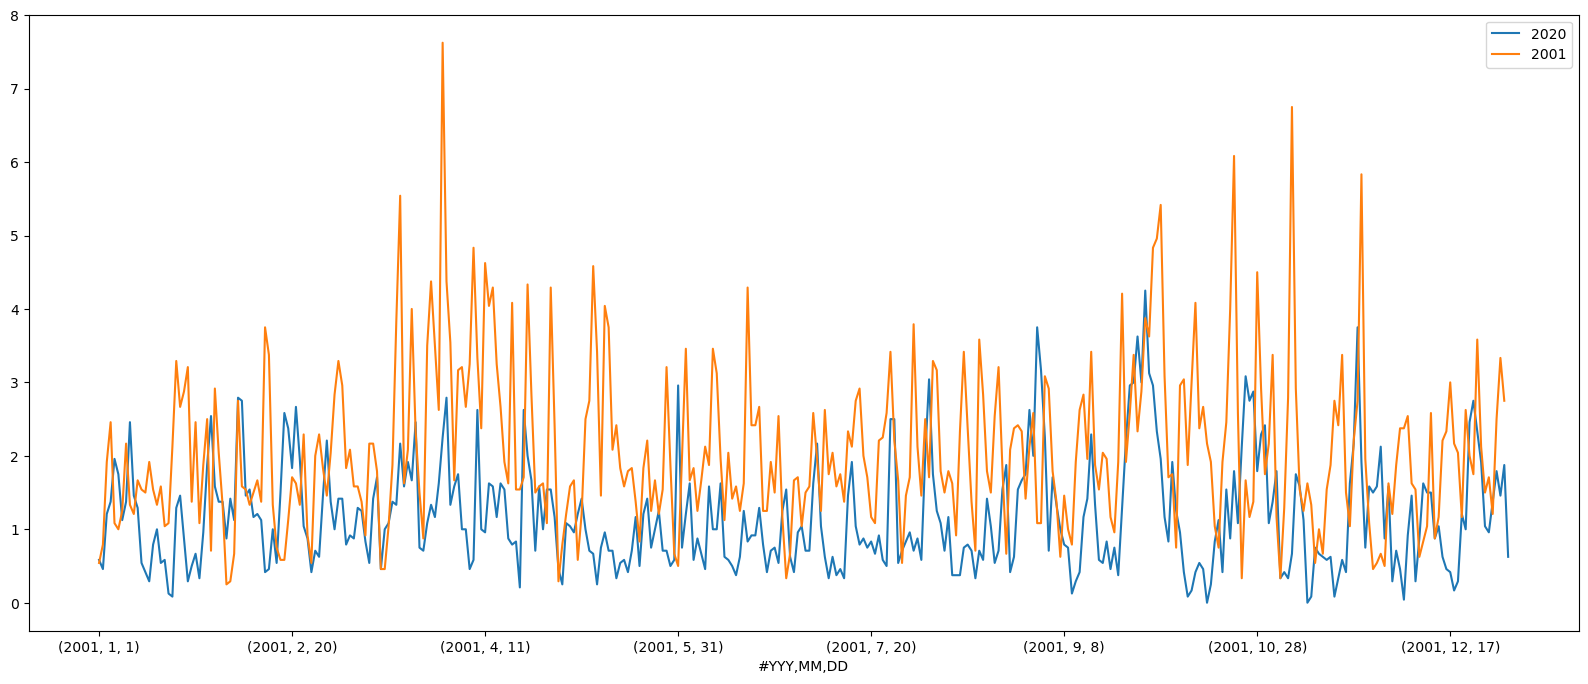

In [40]:
plt.figure(figsize=(20, 8))

year1 = 2020
daily_avgs = data[data['#YYY'] == year1].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year1)
year2 = 2001
daily_avgs = data[data['#YYY'] == year2].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year2)
plt.legend()

In [41]:
ts = pd.Series(data=sndata, index=sndata.)
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot()

SyntaxError: invalid syntax (1639520174.py, line 1)

In [42]:
mod = sm.tsa.statespace.SARIMAX(monthly_avgs, order=(3,0,10), seasonal_order=(1, 1, 0, 43))#originally included order, seasonal_order
res = mod.fit(disp=False)
print(res.summary())

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [43]:
y = res.predict(start=0,end=75000)
plt.plot(y, alpha=0.5)
#plt.plot(test)
plt.plot(sndata['SS#'],alpha=0.5)
plt.legend(['Predicted', 'Data'])


c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


KeyboardInterrupt: 